In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from matlab_functions import *

(215, 126)


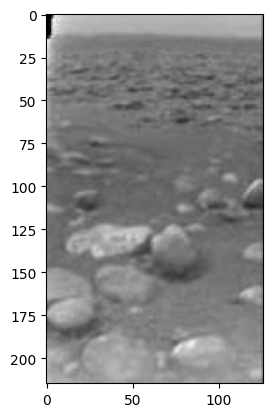

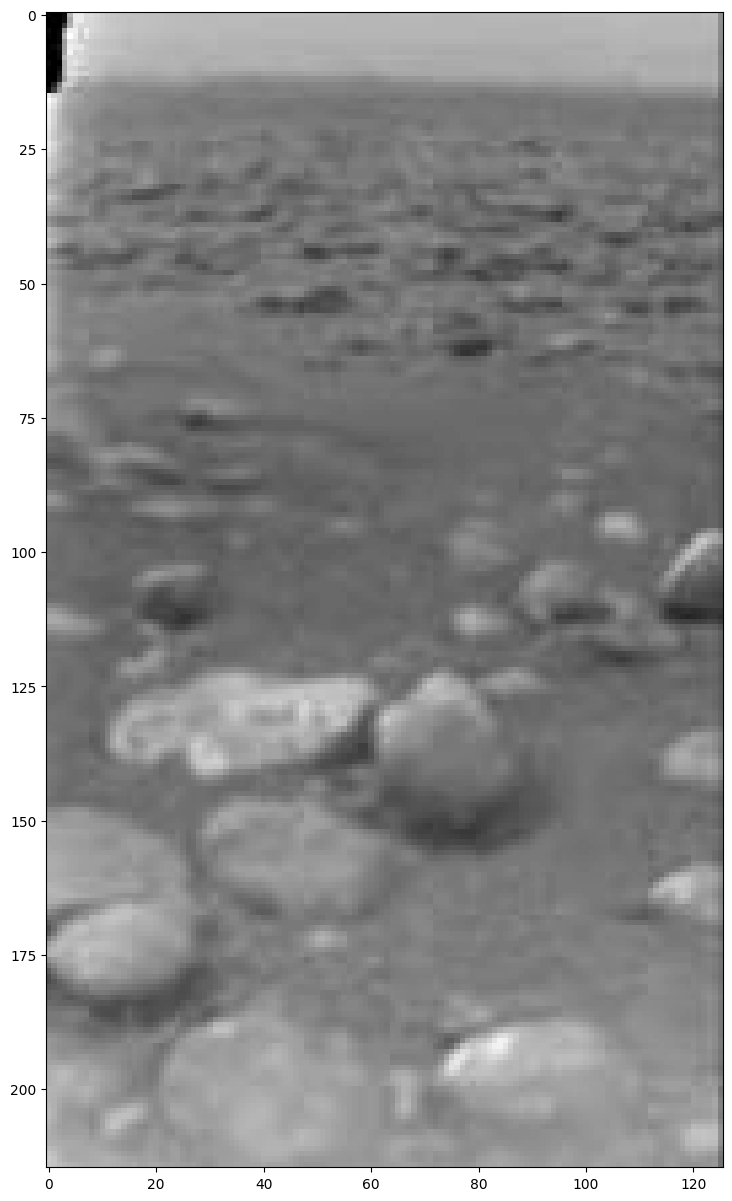

In [2]:


titan = Image.open("titan.jpg")
titan_array = np.array(titan).astype(np.double)
tmax = titan_array.max()
tmin = titan_array.min()
titan_array = titan_array / tmax
print(titan_array.shape)

plt.imshow(titan_array, cmap="gray")
plt.rcParams['figure.figsize'] = [20, 15]
plt.rcParams['figure.dpi'] = 100
plt.show()

titan_1d = titan_array.flatten()

plt.imshow(titan_1d.reshape(215, 126), cmap="gray")
plt.rcParams['figure.figsize'] = [20, 15]
plt.rcParams['figure.dpi'] = 100
plt.show()

## Strategy for project 1

I believe we have to divide the image in a bunch of chunks, at least for the covariance matrix estimation part, since
otherwise it is way to computationally heavy. So we iterate over block of ish 40-50x40-50 and assume regression coefficients for intercept, x and y that are to be estimat and then do the normal procedure with least squares -> covariance estimation -> gls estimation. We then combine all the predictions from the subimages.

### Setting up the seen and missing values, indexes etc

In [3]:

# add X and Y coordinate values
xmax = titan_array.shape[1]
ymax = titan_array.shape[0]
size = 60
spread_x = np.arange(0, xmax)
spread_y = np.arange(0, ymax)
X, Y = np.meshgrid(spread_x, spread_y)
X_cov = X.flatten()
Y_cov = Y.flatten()

covariates = np.vstack((np.ones((X_cov.shape[0])), X_cov, Y_cov)).T

tindex = np.arange(0, titan_array.shape[0]*titan_array.shape[1])
tp = 0.5
tindex_o = np.random.choice(tindex, size=round(tindex.shape[0]*tp), replace=False)
# Could do smarter sampling above, i.e. instead shuffle tindex as: np.random.shuffle(tindex)
# and then take the first round(tindex.shape[0]*tp) elements
# but setdiff1d seems like a good function to know about.
tindex_m = np.setdiff1d(tindex, tindex_o)

observed_values = titan_1d[tindex_o]
missing_values = titan_1d[tindex_m]

# dist matrix and stuff for variogram estimation
loc = np.column_stack((X_cov, Y_cov))

loc_o = loc[tindex_o, :]
loc_m = loc[tindex_m, :]
covariates_o = covariates[tindex_o, :]
covariates_m = covariates[tindex_m, :]
print(loc)


[[  0   0]
 [  1   0]
 [  2   0]
 ...
 [123 214]
 [124 214]
 [125 214]]


### Estimating parameters with OLS for variogram estimation

In [4]:
# estimate parameters LSE then GLS

lse = np.linalg.solve(covariates_o.T @ covariates_o, covariates_o.T @ observed_values)
e = observed_values - covariates_o @ lse
print(lse)

[ 4.89486944e-01 -3.61465533e-04  2.64892786e-04]


### Empirical variogram

In [5]:
emp_v = emp_variogram(loc_o, e, 100)

### LSE of variogram parameters

In [6]:
lse_estimates = cov_ls_est(e, 'matern' , emp_v) #Least-squares estimation of a Mat rn variogram to the binned estimate

h = np.linspace(0, 250, 1000)
mat_v_new = matern_variogram(h,lse_estimates["sigma"],lse_estimates["kappa"],lse_estimates["nu"],lse_estimates["sigma_e"])
print(lse_estimates)

{'sigma': 0.4305386036711803, 'kappa': 1.2228137098033357e-05, 'nu': 0.20676518678665803, 'sigma_e': 0.028885089937597683}


### PLot of variogram estimations

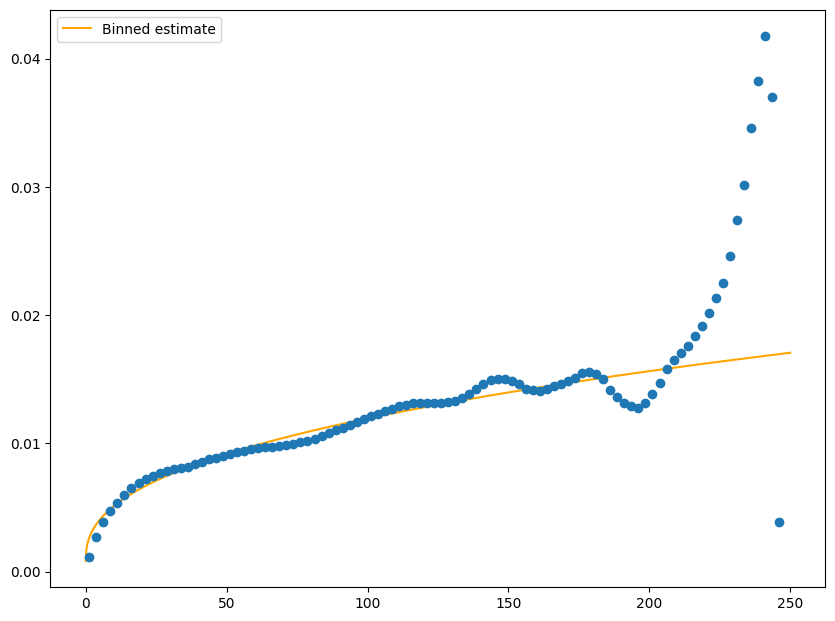

In [7]:
plt.rcParams['figure.figsize'] = [10, 7.5]
plt.rcParams['figure.dpi'] = 100
plt.plot(h,mat_v_new, color="orange")
plt.plot(emp_v["h"], emp_v["variogram"],'o')
plt.legend(["Binned estimate"])
plt.show()
#Estimated variogram
#True vs Estimated variogram


### Covariance matrix for observed values

In [8]:
# Covariance matrix
So = np.zeros((loc_o.shape[0], loc_o.shape[0]))
for i in range(loc_o.shape[0]):
    So[i, i:] = matern_covariance(np.sqrt(np.sum((loc_o[i, :] - loc_o[i:, :])**2, axis=1)) , lse_estimates["sigma"], lse_estimates["kappa"], lse_estimates["nu"])

So = So + np.triu(So, k=1).T
# For memory reasons, we can delete the distance matrix Do


#### Adding the nugget

In [9]:
So = (lse_estimates["sigma_e"]**2) * np.eye(loc_o.shape[0]) + So

In [10]:
So

array([[0.18619772, 0.17157039, 0.17686063, ..., 0.17114367, 0.17342165,
        0.17673578],
       [0.17157039, 0.18619772, 0.17351372, ..., 0.1799084 , 0.17687222,
        0.17288513],
       [0.17686063, 0.17351372, 0.18619772, ..., 0.17295907, 0.17596637,
        0.17849378],
       ...,
       [0.17114367, 0.1799084 , 0.17295907, ..., 0.18619772, 0.17588081,
        0.17229301],
       [0.17342165, 0.17687222, 0.17596637, ..., 0.17588081, 0.18619772,
        0.17522069],
       [0.17673578, 0.17288513, 0.17849378, ..., 0.17229301, 0.17522069,
        0.18619772]])

### GLS estimation of parameters for spatial regression

In [11]:
gls = np.linalg.solve(covariates_o.T @ np.linalg.solve(So, covariates_o), covariates_o.T @ np.linalg.solve(So, observed_values))

In [65]:
print(gls)

[ 1.86121546e+00 -3.51501448e-05 -1.25308822e-04]


### Setup for kriging, calculate Sop

In [13]:
from scipy.spatial import distance_matrix

Dom = distance_matrix(loc_o, loc_m)
Som = np.zeros([loc_o.shape[0], loc_m.shape[0]])
half = loc_m.shape[0]//2
for i in range(loc_o.shape[0]):
    Som[i, :half] = matern_covariance(Dom[i, :half],
                          lse_estimates['sigma'], 
                          lse_estimates['kappa'],
                          lse_estimates['nu'])
    Som[i, half:] = matern_covariance(Dom[i, half:],
                          lse_estimates['sigma'], 
                          lse_estimates['kappa'],
                          lse_estimates['nu'])

Dom = None

### Kriging predictions

In [14]:
krig = covariates_m @ gls + Som.T @ np.linalg.solve(So, observed_values - covariates_o @ gls)

### Plotting results

(-0.5, 125.5, 214.5, -0.5)

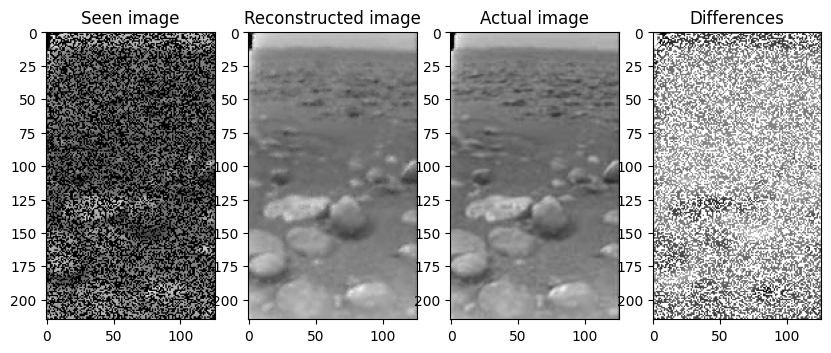

In [16]:
reconstructed_image = tindex
reconstructed_image[tindex_m] = krig
reconstructed_image[tindex_o] = observed_values

seen_image = titan_1d
seen_image[tindex_m] = 0

Reconstructed_image = np.zeros((titan_array.shape[0]*titan_array.shape[1], ))
Reconstructed_image[tindex_o] = observed_values
Reconstructed_image[tindex_m] = krig

plt.rcParams['figure.figsize'] = [10, 7.5]
plt.rcParams['figure.dpi'] = 100
fig, ax = plt.subplots(1, 4)
ax[0].imshow(seen_image.reshape(titan_array.shape[0], titan_array.shape[1]), cmap="gray")
ax[0].set_title("Seen image")
ax[0].axis('image')
ax[1].imshow(Reconstructed_image.reshape(titan_array.shape[0], titan_array.shape[1]), cmap="gray")
ax[1].set_title("Reconstructed image")
ax[1].axis('image')
ax[2].imshow(titan_array, cmap="gray")
ax[2].set_title("Actual image")
ax[2].axis('image')
ax[3].imshow((titan_1d - Reconstructed_image).reshape(titan_array.shape[0], titan_array.shape[1]), cmap="gray")
ax[3].set_title("Differences")
ax[3].axis('image')